# Single-Cell rEgulatory Network Inference and Clustering

*by Anton Crombach, anton.crombach@inria.fr*, (first draft, February 17, 2020)

The lab of Stein Aerts (see the [website](https://aertslab.org/)) developed a tool for looking at single cell data, that is an alternative to the default approach of dimension reduction, Louvain clustering, and t-SNE plot. They call it SCENIC. It is a three-step process, as you can read in the github repo: [pySCENIC](https://github.com/aertslab/pySCENIC). Below I give a summary of the steps:

1. Find for a list of transcription factors (TFs), their target genes by looking at co-expressed genes. The result is a list of `regulons`, a bunch of TFs that co-express with other genes.

The `arboreto` package is used for step 1. It performs a [Stochastic Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting), a type of machine-learning -- an [ensemble method](https://en.wikipedia.org/wiki/Gradient_boosting) to be precise. It consists of many small decision trees (with rather weak performance) that together predict well which TF regulates which target genes.

2. Prune the regulons for TF targets that do not have an overrepresentation of motifs in the genomic region around the transcription start site (TSS).

This step requires that you have a `ranking database`, which you can find [here](https://resources.aertslab.org/cistarget/). These are genomic regions annotated for TF motifs around their TSSs. And it requires a list of which TF binds which motif, found [here](https://github.com/aertslab/pySCENIC/tree/master/resources).

3. For each cell, calculate how much a regulon explains the expression of genes in the cell. This is called an enrichment test and measured as the Area Under The ROC Curve (AUC) of the genes that define this regulon.

A introductory explanation of what ROC curves etc are, is found [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5?gi=31b59c71a7fd). Wikipedia has articles as well, of course (look [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).

In [1]:
print("hello world")

hello world


In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
import pyscenic

import seaborn as sns

# Specialized container datatypes, i.e. specialized versions of lists, dictionaries, etc.
import collections as coll
# Date and time functions, useful for timestamping file names of figures.
import datetime
# Functional programming tools.
import itertools as itt
# Pretty-printing text by wrapping and filling lines.
import textwrap as tw


# "Default" plotting package of Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
# Matplotlib colours module.
import matplotlib.colors as mpcol


# Single Cell Analysis in Python
import scanpy as sc

import scipy #to help read files

DATA_FOLDER = "D:\Robin/pyscenic"
OUT_FOLDER = "D:\Robin/pyscenic_filtered_projection_neurons"
SCHEDULER = ""

DATABASES_GLOB = os.path.join(DATA_FOLDER, "mm*.feather") #I'm using mm10 whereas his original code is mm9 - will that be a problem?
MOTIF_ANNOTATIONS_FNAME = os.path.join(DATA_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(DATA_FOLDER, 'mm_tfs.txt')
#MM_TFS_FNAME = os.path.join(DATA_FOLDER, 'mm_transcription_factors', 'mm_tfs.csv') #I had to download as csv instead

EX_MATRIX_FNAME = os.path.join(DATA_FOLDER, "ex_matrix.p")
ADJACENCIES_FNAME = os.path.join(OUT_FOLDER, "2020-Mar_26_nuc_adjacencies.p")
MODULES_FNAME = os.path.join(OUT_FOLDER, "modules.p")

REGULONS_FNAME = os.path.join(OUT_FOLDER, "regulons_nuc.p")
REGULONS_CSV = os.path.join(OUT_FOLDER, "regulons_nuc.csv")
MOTIFS_FNAME = os.path.join(OUT_FOLDER, "motifs_nuc.csv")

AUC_FNAME = os.path.join(OUT_FOLDER, "projection_neurons_auc_mtx.p")
BINARIZED_FNAME = os.path.join(OUT_FOLDER, "binarized_mtx.p")

CLUSTERS_FNAME = os.path.join(OUT_FOLDER, "pyscenic_clusters.p")

#standard ex_matrix - R1 + R3
ST_MATRIX_FNAME = "../../OB_single_seq_data/R1_R3_counts_dense.p"
ST_AUC_FNAME = "../../OB_single_seq_data/R1_R3_auc.p"

C:\tools\Anaconda3\envs\robin_pyscenic\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\tools\Anaconda3\envs\robin_pyscenic\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
%run scanpy_aid.py

# Old: reading in data, filtering (mitochondria)

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_versions()

input_path = 'D:Robin/Single_seq_data/OB_single_seq_data/Replicate_1/filtered_feature_bc_matrix/'
data_r1 = read_piriform_adult(input_path)
data_r1.obs['replicate'] = 'r1'

input_path = 'D:Robin/Single_seq_data/OB_single_seq_data/Replicate_2/filtered_feature_bc_matrix/'
data_r2 = read_piriform_adult(input_path)
data_r2.obs['replicate'] = 'r2'

input_path = 'D:Robin/Single_seq_data/OB_single_seq_data/Replicate_3/filtered_feature_bc_matrix/'
data_r3 = read_piriform_adult(input_path)
data_r3.obs['replicate'] = 'r3'

# Pooling the two replicates
data = data_r1.concatenate(data_r2,data_r3)

In [36]:
data = data_r1.concatenate(data_r2,data_r3)
data

AnnData object with n_obs × n_vars = 67376 × 31055 
    obs: 'batch', 'replicate'

In [37]:
# Set the cut-off for allowed mitochondrial content at 1 percent
MITO_CUTOFF = 0.003 #from Sara's notebook

mito_genes = [name for name in data.var_names if name.startswith('mt-')]
# For each cell compute fraction of counts in mito genes vs. all genes.
# The `.A1` is only necessary because X is sparse. It transforms to a 
# dense array after summing
data.obs['percent_mito'] = np.sum(
    data[:, mito_genes].X, axis=1).A1 / np.sum(data.X, axis=1).A1

# Add the total counts per cell as observations-annotation to data
data.obs['n_counts'] = data.X.sum(axis=1).A1

# Computing how many genes are expressed in each cell
data.obs['n_genes'] = np.sum(data.X > 0, axis=1).A1

# Computing in how many cells a gene is found
data.var['n_cells'] = np.sum(data.X > 0, axis=0).A1

In [38]:
# How many cells do we classify as dying?
n_dying = np.sum(data.obs['percent_mito'] >= MITO_CUTOFF)
n_alive = np.sum(data.obs['percent_mito'] < MITO_CUTOFF)

print("Dying: {}\nAlive: {}".format(n_dying, n_alive))

Dying: 20271
Alive: 47105


In [39]:
# We remove cells that have a high fraction of mito genes, as that marks dead/dying cells.
data = data[data.obs['percent_mito'] < MITO_CUTOFF, :]

In [40]:
# Function to select only a specific set of cells
def select_cells_expressing_gene(data, gene):
    """Select cells (rows) in the matrix that have nonzero values for the given gene."""
    return data[data[:, gene].X > 0,]

# Let's select for mature neurons
#favorite_genes = ['Rbfox3', 'Slc17a7']
favorite_genes = ['Syt1', 'Slc17a7'] #from Sara

In [41]:
# This didn't work, so I did it manually below 
## The actual selection of mature neurons
# fav_data = data
# for fg in favorite_genes:
#     fav_data = select_cells_expressing_gene(fav_data, fg)

# #data = fav_data
# fav_data

In [42]:
#manually finding cells that satisfy my conditions
obs_list = []
for obs in data.obs_names:
    if data[obs,'Slc17a7'].X > 0 and data[obs,'Syt1'].X > 0:
        obs_list.append(obs)

In [43]:
#print(obs_list)

In [44]:
#adata_subset = adata[:, list_of_variable_names]
fav_data = data[obs_list,:]

In [45]:
data = fav_data

In [46]:
# Filtering out any cells with less than 2 genes expressed and 
# any genes that are expressed in less than 2 cells.
sc.pp.filter_cells(data, min_genes=2)
sc.pp.filter_genes(data, min_cells=2)

Trying to set attribute `.obs` of view, copying.


filtered out 5965 genes that are detected in less than 2 cells


In [47]:
# Always check if our data makes sense, which is usually done 
# by eye-balling the dimensions of the RNA count matrix
print(data)

AnnData object with n_obs × n_vars = 13753 × 25090 
    obs: 'batch', 'replicate', 'percent_mito', 'n_counts', 'n_genes'
    var: 'n_cells'


In [48]:
# From scanpy AnnData object to pandas dataframe
ex_matrix = pd.DataFrame(data.X.todense(), index=data.obs_names, columns=data.var_names)

# Check dimensions, grnboost2 expects rows = cells, columns = genes
ex_matrix.shape

(13753, 25090)

In [ ]:
#fname = 'D:Robin/Single_seq_data/final_nuclei/full.loom' #all cells
fname = 'D:Robin/Single_seq_data/final_nuclei/subcluster.loom' #only excitatory neurons
data = sc.read_loom(fname,sparse=False)

In [9]:
import loompy

In [10]:
print(loompy.__version__)

2.0.16


# New: reading in data

In [ ]:
from scipy import io as io
input_path = os.path.join('D:Robin','Single_seq_data','OB_single_seq_data','Replicate_1','filtered_feature_bc_matrix')
r1 = pd.DataFrame(
    io.mmread(os.path.join(input_path,'matrix.mtx')).T.todense(),
    columns = pd.read_csv(os.path.join(input_path, 'features.tsv'), header=None, sep='\t')[1],
    index = pd.read_csv(os.path.join(input_path, 'barcodes.tsv'), header=None)[0]
)

input_path = os.path.join('D:Robin','Single_seq_data','OB_single_seq_data','Replicate_2','filtered_feature_bc_matrix')
r2 = pd.DataFrame(
    io.mmread(os.path.join(input_path,'matrix.mtx')).T.todense(),
    columns = pd.read_csv(os.path.join(input_path, 'features.tsv'), header=None, sep='\t')[1],
    index = pd.read_csv(os.path.join(input_path, 'barcodes.tsv'), header=None)[0]
)

input_path = os.path.join('D:Robin','Single_seq_data','OB_single_seq_data','Replicate_3','filtered_feature_bc_matrix')
r3 = pd.DataFrame(
    io.mmread(os.path.join(input_path,'matrix.mtx')).T.todense(),
    columns = pd.read_csv(os.path.join(input_path, 'features.tsv'), header=None, sep='\t')[1],
    index = pd.read_csv(os.path.join(input_path, 'barcodes.tsv'), header=None)[0]
)

In [ ]:
full_data = pd.concat([r1,r2,r3])

In [ ]:
full_data

# pyscenic

In [119]:
# Read in the list of mouse transcription factors
tf_names = load_tf_names(MM_TFS_FNAME)


In [ ]:
#so I moved it to a csv instead
#tf_names = pd.read_csv(MM_TFS_FNAME)['Symbol'].to_list()

# Step 1, detect co-expression with grnboost

##### I have been having problems with Dask (common), so I've been using the following in terminal for GRNBoost:
##### caffeinate python arboreto_with_multiprocessing.py subcluster_ex_mtx.csv  mm_tfs.txt -o adjacencies_5.csv

In [2]:
# Setting up a working environment for multiple CPUs
from dask.distributed import Client, LocalCluster
worker_kwargs = {'local_dir': '/tmp'}
cluster = LocalCluster(**worker_kwargs)
custom_client = Client(cluster)
custom_client

C:\tools\Anaconda3\envs\robin_pyscenic\lib\site-packages\distributed\nanny.py:160: UserWarning: The local_dir keyword has moved to local_directory
  warnings.warn("The local_dir keyword has moved to local_directory")


<Client: 'tcp://127.0.0.1:53408' processes=6 threads=36, memory=823.19 GB>

In [150]:
len(projection_data.values[1])

31055

In [156]:
import dask

In [177]:
from arboreto.algo import grnboost2 as my_grnboost

In [ ]:
adjacencies = my_grnboost(projection_data.to_numpy(), gene_names = projection_data.columns, tf_names=tf_names, verbose=True)

In [ ]:
# If grnboost2 generates an error in line 214 of arboreto, change "as_matrix" to "as_numpy"
## I tried following his instruction above and now it's throwing an error about numpy?? so maybe the issue is with ex_matrix itself?
adjacencies = grnboost2(projection_data.to_numpy(), gene_names = projection_data.columns, tf_names=tf_names, verbose=True)
#adjacencies = grnboost2(projection_data.to_numpy(), gene_names = projection_data.columns, tf_names=tf_names, seed=1982, client_or_address=custom_client)

The system cannot find the file specified.


In [ ]:
# What do adjacencies look like? A very long list of TFs 
# and their targets with a relative importance.
adjacencies

In [72]:
adjacencies = pd.DataFrame(adj)

In [74]:
ex_df = pd.DataFrame(ex_matrix)

### Back to Anton's code to clean up after grnboost

In [ ]:
adjecencies.to_csv('adjecencies.csv')

In [5]:
# Saving costly data, grnboost2 takes time!
with open('../Data/2020-Mar-26_nuc_adjacencies.p', 'wb') as f:
    pickle.dump(adj, f)

In [5]:
folder = '../../pyscenic_data/final_nuclei'
adj_1 = pd.read_csv(os.path.join(folder, "adjacencies_1.csv"))

In [ ]:
ex_matrix

In [6]:
folder = '../../OB_single_seq_data/final_nuclei'
ex_matrix = pd.read_csv(os.path.join(folder, "subcluster_ex_mtx.csv"))

In [19]:
ex_matrix.to_pickle(EX_MATRIX_FNAME)

In [12]:
ex_matrix.set_index('Unnamed: 0',inplace=True)

In [ ]:
adjacencies.head()

In [56]:
# By default we only keep *activating* TF-regulator interactions.
# See https://github.com/aertslab/pySCENIC/blob/master/src/pyscenic/utils.py line 204 for the function code

modules = list(modules_from_adjacencies(adjacencies, new_ex_mtx))


2020-04-10 17:32:38,575 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-04-10 17:32:38,577 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-04-10 17:35:34,021 - pyscenic.utils - INFO - Creating modules.


### filtering modules for those found in 4/5 runs because GRNBoost is stochastic

In [18]:
modules_list = []

num_runs = 5
for i in range(1,1+num_runs):
    name = 'adjacencies_' + str(i) + '.csv'
    folder = '../../pyscenic_data/final_nuclei'
    
    adj = pd.read_csv(os.path.join(folder, name))
    
    modules = list(modules_from_adjacencies(adj, ex_matrix))
    modules_list.append(modules)


2020-07-06 14:23:53,635 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-06 14:23:53,728 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-06 14:40:06,342 - pyscenic.utils - INFO - Creating modules.

2020-07-06 14:44:13,994 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-06 14:44:14,140 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the

In [29]:
# Saving costly data
MODULES_FNAME = '../../pyscenic_data/final_nuclei/modules_list.p'
with open(MODULES_FNAME, 'wb') as f:
    #pickle.dump(modules, f)
    pickle.dump(modules_list, f)

# Step 2, prune for targets with enriched TF binding motifs

In [5]:
# Read in data if we restarted from an old session
MODULES_FNAME = 'D:Robin/pyscenic/final_nuclei/modules_list.p'
#modules = pickle.load(open(MODULES_FNAME, 'rb'))
modules_list = pickle.load(open(MODULES_FNAME, 'rb'))

In [7]:
len(modules_list)

5

In [8]:
# Read in the ranking database(s) --- only 1 in my case ---
# that contain the genomic regions around TSS.
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="mm10__refseq-r80__500bp_up_and_100bp_down_tss"),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-7species")]

In [9]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
regulons_list = []
for modules in modules_list:
    with ProgressBar():
        df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

    # Create regulons from this table of enriched motifs.
    regulons = df2regulons(df)
    regulons_list.append(regulons)

[########################################] | 100% Completed |  6min 21.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[########################################] | 100% Completed |  6min 21.2s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[########################################] | 100% Completed |  6min 24.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[########################################] | 100% Completed |  6min 18.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[########################################] | 100% Completed |  6min 21.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [10]:
len(regulons_list)

5

In [12]:
# Save the enriched motifs and the discovered regulons to disk.
#df.to_csv(MOTIFS_FNAME)
REGULONS_FNAME = 'D:Robin/pyscenic/final_nuclei/regulons_list.p'
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons_list, f)

# Reading in lots of adjacencies, saving their regulons

In [3]:
# Read in the ranking database(s) --- only 1 in my case ---
# that contain the genomic regions around TSS.
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]

In [4]:
regulons_list = []
num_runs = 100

folder = 'D:Robin/pyscenic/final_nuclei/adjacencies'

ex_matrix = pd.read_csv(os.path.join(folder, 'subcluster_ex_mtx.csv'))

In [6]:
ex_matrix.set_index('Unnamed: 0',inplace=True)

In [ ]:
#for i in range(1,num_runs+1): #because I did 1 indexing
for i in range(14,114):  #STARTED WITH 14 BECAUSE OF FILE TRANSFER --> WILL HAVE TO GO BACK AND DO THE REST
    if i <= 100:
        name = 'adjacencies_' + str(i) + '.csv'
    else:
        name = 'adjacencies_' + str(i-100) + '.csv'
    
    print(name)
    
    adj = pd.read_csv(os.path.join(folder, name))
    
    modules = list(modules_from_adjacencies(adj, ex_matrix))
    
    with ProgressBar():
        df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

    # Create regulons from this table of enriched motifs.
    regulons = df2regulons(df)
    regulons_list.append(regulons)
    #save regulons_list every iteration in case something goes wrong halfway through
    REGULONS_FNAME = os.path.join(folder,'regulons_list.p')
    with open(REGULONS_FNAME, "wb") as f:
        pickle.dump(regulons_list, f)

adjacencies_14.csv



2020-07-27 00:18:48,226 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 00:18:48,228 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 00:20:10,201 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min  8.1s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_15.csv



2020-07-27 00:28:54,800 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 00:28:54,801 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 00:30:17,111 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min  0.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_16.csv



2020-07-27 00:38:55,090 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 00:38:55,092 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 00:40:17,368 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min 10.2s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_17.csv



2020-07-27 00:49:05,486 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 00:49:05,487 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 00:50:28,812 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min 11.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_18.csv



2020-07-27 00:59:19,037 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 00:59:19,040 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 01:00:42,356 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min 16.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_19.csv



2020-07-27 01:09:37,824 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 01:09:37,826 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 01:11:00,829 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min 21.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_20.csv



2020-07-27 01:20:01,652 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 01:20:01,654 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 01:21:24,838 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min 36.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_21.csv



2020-07-27 01:30:40,080 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 01:30:40,082 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 01:32:02,597 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  6min 49.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_22.csv



2020-07-27 01:41:31,786 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 01:41:31,788 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 01:42:53,801 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  7min  3.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_23.csv



2020-07-27 01:52:37,560 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 01:52:37,562 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 01:53:59,867 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  7min 20.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_24.csv



2020-07-27 02:04:02,322 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 02:04:02,324 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 02:05:26,207 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  7min 36.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_25.csv



2020-07-27 02:15:46,578 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 02:15:46,580 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 02:17:10,521 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  7min 51.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_26.csv



2020-07-27 02:27:45,172 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 02:27:45,175 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 02:29:09,080 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  8min  2.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_27.csv



2020-07-27 02:39:55,491 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 02:39:55,494 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 02:41:19,490 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  8min 17.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_28.csv



2020-07-27 02:52:21,167 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 02:52:21,170 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 02:53:45,105 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  8min 29.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_29.csv



2020-07-27 03:04:59,534 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 03:04:59,537 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 03:06:21,532 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  8min 37.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_30.csv



2020-07-27 03:17:43,853 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 03:17:43,857 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 03:19:06,079 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  8min 58.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_31.csv



2020-07-27 03:30:50,211 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 03:30:50,215 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 03:32:11,826 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  9min  5.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_32.csv



2020-07-27 03:44:04,863 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 03:44:04,867 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 03:45:27,173 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  9min 22.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_33.csv



2020-07-27 03:57:39,048 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 03:57:39,052 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 03:59:02,797 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  9min 39.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_34.csv



2020-07-27 04:11:29,247 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 04:11:29,251 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 04:12:53,545 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed |  9min 51.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_35.csv



2020-07-27 04:25:35,011 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 04:25:35,016 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 04:26:58,348 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 10min 10.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_36.csv



2020-07-27 04:39:58,545 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 04:39:58,550 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 04:41:22,776 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 10min 31.1s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_37.csv



2020-07-27 04:54:41,561 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 04:54:41,566 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 04:56:05,909 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 10min 37.2s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_38.csv



2020-07-27 05:09:34,081 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 05:09:34,086 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 05:10:56,173 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 10min 52.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_39.csv



2020-07-27 05:24:39,663 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 05:24:39,668 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 05:26:01,474 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 11min 34.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_40.csv



2020-07-27 05:40:25,354 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 05:40:25,360 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 05:41:47,565 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 11min 34.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_41.csv



2020-07-27 05:56:14,230 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 05:56:14,235 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 05:57:37,872 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 12min  0.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_42.csv



2020-07-27 06:12:32,596 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 06:12:32,601 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 06:13:56,430 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 12min 13.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_43.csv



2020-07-27 06:29:03,678 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 06:29:03,685 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 06:30:27,794 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 12min 43.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_44.csv



2020-07-27 06:46:06,897 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 06:46:06,902 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 06:47:31,592 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 13min  2.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_45.csv



2020-07-27 07:03:25,846 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 07:03:25,852 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 07:04:47,044 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 13min 29.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_46.csv



2020-07-27 07:21:09,089 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 07:21:09,095 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 07:22:30,415 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 13min 39.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_47.csv



2020-07-27 07:39:06,727 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 07:39:06,734 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 07:40:27,527 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 14min 22.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_48.csv



2020-07-27 07:57:46,249 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 07:57:46,255 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 07:59:09,608 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 14min 56.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_49.csv



2020-07-27 08:17:02,632 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 08:17:02,639 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 08:18:26,936 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 15min  5.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_50.csv



2020-07-27 08:36:29,712 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 08:36:29,718 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 08:37:52,871 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 15min 36.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_51.csv



2020-07-27 08:56:31,270 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 08:56:31,277 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 08:57:53,872 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 16min  6.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_52.csv



2020-07-27 09:17:02,604 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 09:17:02,611 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 09:18:25,183 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 16min 30.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_53.csv



2020-07-27 09:37:57,558 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 09:37:57,565 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 09:39:19,237 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 16min 50.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_54.csv



2020-07-27 09:59:10,423 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 09:59:10,430 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 10:00:34,530 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 17min 19.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_55.csv



2020-07-27 10:20:58,569 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 10:20:58,577 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 10:22:22,128 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 17min 53.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_56.csv



2020-07-27 10:43:16,674 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 10:43:16,682 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 10:44:39,969 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 18min 20.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_57.csv



2020-07-27 11:06:03,711 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 11:06:03,718 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 11:07:27,052 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 18min 45.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_58.csv



2020-07-27 11:29:17,570 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 11:29:17,578 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 11:30:39,970 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 19min 37.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_59.csv



2020-07-27 11:53:23,562 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 11:53:23,571 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 11:54:45,865 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 19min 47.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_60.csv



2020-07-27 12:17:43,218 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 12:17:43,226 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 12:19:06,213 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 20min 42.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_61.csv



2020-07-27 12:42:58,072 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 12:42:58,081 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 12:44:19,918 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 21min 33.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_62.csv



2020-07-27 13:09:01,722 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 13:09:01,749 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 13:10:22,661 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 23min 23.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_63.csv



2020-07-27 13:36:54,061 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 13:36:54,070 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 13:38:17,338 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 22min 40.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_64.csv



2020-07-27 14:04:04,405 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 14:04:04,414 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 14:05:26,298 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 23min 13.1s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_65.csv



2020-07-27 14:31:49,870 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 14:31:49,880 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 14:33:12,079 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 24min 11.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_66.csv



2020-07-27 15:00:35,563 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 15:00:35,573 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 15:01:58,027 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 24min 28.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_67.csv



2020-07-27 15:29:42,253 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 15:29:42,263 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 15:31:04,096 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 25min 22.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_68.csv



2020-07-27 15:59:37,815 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 15:59:37,830 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 16:00:59,494 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 25min 44.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_69.csv



2020-07-27 16:29:51,836 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 16:29:51,846 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 16:31:14,973 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 26min  3.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_70.csv



2020-07-27 17:00:32,284 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 17:00:32,294 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 17:01:55,053 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 27min 13.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_71.csv



2020-07-27 17:32:23,200 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 17:32:23,211 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 17:33:48,525 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 27min 30.1s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_72.csv



2020-07-27 18:04:37,592 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 18:04:37,603 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 18:06:00,480 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 28min 53.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_73.csv



2020-07-27 18:38:18,228 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 18:38:18,238 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 18:39:40,395 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 29min 17.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_74.csv



2020-07-27 19:12:11,860 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 19:12:11,871 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 19:13:34,367 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 30min  2.9s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_75.csv



2020-07-27 19:46:54,145 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 19:46:54,156 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 19:48:16,233 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 30min 58.1s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_76.csv



2020-07-27 20:22:32,935 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 20:22:32,947 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 20:24:01,949 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 31min 33.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_77.csv



2020-07-27 20:59:00,291 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 20:59:00,306 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 21:00:29,612 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 32min  6.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_78.csv



2020-07-27 21:35:59,311 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 21:35:59,322 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 21:37:28,218 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 33min 13.3s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_79.csv



2020-07-27 22:14:13,989 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 22:14:14,001 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 22:15:47,287 - pyscenic.utils - INFO - Creating modules.


[########################################] | 100% Completed | 33min 28.2s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
adjacencies_80.csv



2020-07-27 22:52:59,663 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-07-27 22:52:59,675 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-07-27 22:54:29,935 - pyscenic.utils - INFO - Creating modules.


[################                        ] | 41% Completed | 28min 48.6s

### keeping only regulons that appear a certain number of times

In [ ]:
%run regulon_prune_aid.py

In [ ]:
prune_mulitple_runs(regulons_list,100,0.80,folder)

In [ ]:
prune_mulitple_runs(regulons_list,100,0.85,folder)

In [ ]:
prune_mulitple_runs(regulons_list,100,0.90,folder)

In [ ]:
prune_mulitple_runs(regulons_list,100,0.95,folder)

# Step 3, calculate enrichment of regulons for single cells

In [55]:
with open(EX_MATRIX_FNAME, "rb") as infile:
    ex_matrix = pickle.load(infile)

In [6]:
ex_matrix = pd.read_csv('D:Robin/pyscenic_filtered_projection_neurons/projection_neurons_matrix.csv')

In [8]:
ex_matrix = ex_matrix.set_index('Unnamed: 0')

In [2]:
REGULONS_FNAME = 'D:Robin/pyscenic/regulons_nuc_og.p'
with open(REGULONS_FNAME, "rb") as infile:
    regulons = pickle.load(infile)

In [3]:
len(regulons)

125

In [4]:
fname = 'D:Robin/Single_seq_data/final_nuclei/full.loom' #all cells
#fname = 'D:Robin/Single_seq_data/final_nuclei/subcluster.loom' #only excitatory neurons
data = ad.read_loom(fname,sparse=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
data.var_names_make_unique()

In [6]:
ex_matrix = pd.DataFrame(data.X,index = data.obs.index,columns = data.var.index)

In [ ]:
ex_matrix

In [7]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)

In [8]:
auc_mtx

Regulon              Alx3(+)  Arid5b(+)   Arnt(+)   Atf2(+)   Atf4(+)  \
Cell                                                                    
AAACCCAAGAAGGATG-1  0.000000   0.062773  0.067293  0.092530  0.072616   
AAACCCAAGGTTGTTC-1  0.000000   0.077857  0.049234  0.073130  0.040652   
AAACCCACACATCATG-1  0.000000   0.031611  0.000000  0.045042  0.036579   
AAACCCACACCAGGTC-1  0.000000   0.014798  0.000000  0.067107  0.070621   
AAACCCACAGCCTTCT-1  0.000000   0.045272  0.000000  0.071329  0.066069   
...                      ...        ...       ...       ...       ...   
TTTGGTTTCCGACGGT-1  0.004389   0.034111  0.025717  0.059924  0.035500   
TTTGTTGAGCGTATGG-1  0.000000   0.019218  0.032334  0.079787  0.074852   
TTTGTTGAGGCCTGAA-1  0.000000   0.196861  0.150915  0.058796  0.022182   
TTTGTTGCATCGGATT-1  0.000000   0.034669  0.000000  0.090913  0.029335   
TTTGTTGTCTCATTGT-1  0.028100   0.119391  0.012550  0.050409  0.025217   

Regulon             Bach2(+)  Barx1(+)  Bcl11a(+)  Bclaf1(+)   Bmyc(+)  ...  \
Cell                                                                    ...   
AAACCCAAGAAGGATG-1  0.052170  0.000000   0.221436   0.075616  0.066317  ...   
AAACCCAAGGTTGTTC-1  0.084710  0.069191   0.037827   0.088560  0.070437  ...   
AAACCCACACATCATG-1  0.069290  0.011305   0.038861   0.067651  0.068468  ...   
AAACCCACACCAGGTC-1  0.054558  0.000000   0.052950   0.069554  0.053184  ...   
AAACCCACAGCCTTCT-1  0.039581  0.020992   0.237316   0.063612  0.047573  ...   
...                      ...       ...        ...        ...       ...  ...   
TTTGGTTTCCGACGGT-1  0.043378  0.027278   0.106510   0.063029  0.062353  ...   
TTTGTTGAGCGTATGG-1  0.056671  0.000000   0.016485   0.087246  0.090979  ...   
TTTGTTGAGGCCTGAA-1  0.057122  0.071622   0.114205   0.036486  0.031967  ...   
TTTGTTGCATCGGATT-1  0.086341  0.000000   0.093121   0.070271  0.053138  ...   
TTTGTTGTCTCATTGT-1  0.119275  0.033912   0.111239   0.048623  0.031639  ...   

Regulon              Usf1(+)   Usf2(+)   Vax1(+)    Yy1(+)  Zfp110(+)  \
Cell                                                                    
AAACCCAAGAAGGATG-1  0.035874  0.030726  0.069778  0.057945   0.061080   
AAACCCAAGGTTGTTC-1  0.060631  0.057461  0.099436  0.059255   0.061929   
AAACCCACACATCATG-1  0.072043  0.070571  0.057486  0.058559   0.068452   
AAACCCACACCAGGTC-1  0.044458  0.036400  0.015952  0.046436   0.057509   
AAACCCACAGCCTTCT-1  0.015908  0.059773  0.011365  0.061999   0.085693   
...                      ...       ...       ...       ...        ...   
TTTGGTTTCCGACGGT-1  0.022206  0.090026  0.028938  0.038016   0.039431   
TTTGTTGAGCGTATGG-1  0.066752  0.039636  0.065601  0.079501   0.096844   
TTTGTTGAGGCCTGAA-1  0.017990  0.014112  0.006169  0.036214   0.050379   
TTTGTTGCATCGGATT-1  0.044767  0.062624  0.081431  0.070072   0.102515   
TTTGTTGTCTCATTGT-1  0.026157  0.015914  0.007552  0.046401   0.095737   

Regulon             Zfp143(+)  Zfp398(+)  Zfp467(+)  Zfp523(+)   Zic1(+)  
Cell                                                                      
AAACCCAAGAAGGATG-1   0.050574   0.000000   0.154908   0.084523  0.084223  
AAACCCAAGGTTGTTC-1   0.068048   0.000000   0.062280   0.041019  0.216532  
AAACCCACACATCATG-1   0.058040   0.000000   0.067105   0.044156  0.000000  
AAACCCACACCAGGTC-1   0.054679   0.000000   0.021993   0.062224  0.000000  
AAACCCACAGCCTTCT-1   0.039799   0.000000   0.043512   0.097339  0.000000  
...                       ...        ...        ...        ...       ...  
TTTGGTTTCCGACGGT-1   0.051891   0.000000   0.053379   0.019462  0.000000  
TTTGTTGAGCGTATGG-1   0.053367   0.000000   0.064017   0.024625  0.020059  
TTTGTTGAGGCCTGAA-1   0.061510   0.000000   0.050749   0.020168  0.000000  
TTTGTTGCATCGGATT-1   0.100539   0.389369   0.044790   0.030555  0.004621  
TTTGTTGTCTCATTGT-1   0.043638   0.000000   0.026411   0.203622  0.033083  

[31703 rows x 125 columns]

In [9]:
#AUC_FNAME = 'D:Robin/pyscenic/final_nuclei/subcluster_auc_mtx.p'
AUC_FNAME = 'D:Robin/pyscenic/full_auc_mtx.p'
auc_mtx.to_pickle(AUC_FNAME)

In [ ]:
with open('../../pyscenic_data/pyscenic_pipeline/regulons_nuc.p', "rb") as infile:
    regulons = pickle.load(infile)

In [33]:
with open('D:Robin/bulk_counts.p', "rb") as infile:
    bulk_matrix = pickle.load(infile)

In [35]:
bulk_matrix

Gnai3  Pbsn  Cdc45  H19  Scml2  Apoh    Narf   Cav2   Klf6  Scmh1  \
PCX_1  1216.0   0.0   65.0  0.0   10.0   2.0   466.0  839.0  454.0  480.0   
PCX_2   784.0   0.0   50.0  0.0   19.0   0.0   373.0  323.0  377.0  329.0   
PCX_3   789.0   0.0   39.0  0.0   27.0   0.0   365.0  336.0  272.0  607.0   
AON_1  2027.0   0.0   60.0  1.0   41.0  24.0  1071.0  507.0  933.0  762.0   
AON_2  1865.0   0.0   79.0  2.0   22.0   9.0   930.0  383.0  695.0  327.0   
AON_3  2115.0   0.0   37.0  0.0   14.0  17.0   872.0  582.0  710.0  386.0   

       ...  Gm48681  Gm18626  Gm40849  9330199G10Rik  4930556H04Rik  Gm18631  \
PCX_1  ...      0.0      0.0      1.0            0.0            0.0      0.0   
PCX_2  ...      0.0      0.0      0.0            0.0            0.0      0.0   
PCX_3  ...      0.0      0.0      1.0            0.0            0.0      0.0   
AON_1  ...      0.0      0.0      8.0            0.0            0.0      0.0   
AON_2  ...      0.0      0.0      2.0            2.0            0.0      0.0   
AON_3  ...      0.0      0.0      0.0            0.0            0.0      0.0   

       Gm33115  Gm48139  Gm3800  2900042G08Rik  
PCX_1      0.0      4.0     0.0            0.0  
PCX_2      0.0     14.0     0.0            0.0  
PCX_3      0.0      4.0     0.0            0.0  
AON_1      1.0     15.0     0.0            0.0  
AON_2      2.0      4.0     0.0            0.0  
AON_3      1.0      3.0     1.0            0.0  

[6 rows x 51912 columns]

In [36]:
bulk_auc_mtx = aucell(bulk_matrix, regulons, num_workers=4)

In [37]:
bulk_auc_mtx

Regulon  Alx3(+)  Arid3a(+)    Arx(+)   Atf1(+)   Atf2(+)  Bach1(+)  Bach2(+)  \
Cell                                                                            
PCX_1        0.0   0.037888  0.272391  0.202203  0.132905  0.092728  0.090572   
PCX_2        0.0   0.042872  0.230943  0.218014  0.137258  0.106148  0.115089   
PCX_3        0.0   0.038936  0.257713  0.201183  0.142637  0.108010  0.135667   
AON_1        0.0   0.045834  0.317585  0.204862  0.179762  0.100444  0.111497   
AON_2        0.0   0.014086  0.288033  0.188729  0.123910  0.100908  0.082042   
AON_3        0.0   0.023080  0.287175  0.201856  0.144576  0.099289  0.090295   

Regulon  Barx1(+)  Bcl11a(+)  Bclaf1(+)  ...   Usf2(+)   Xbp1(+)    Yy1(+)  \
Cell                                     ...                                 
PCX_1    0.074387   0.138389   0.169247  ...  0.189745  0.246128  0.216239   
PCX_2    0.077831   0.125189   0.160453  ...  0.161528  0.240079  0.189671   
PCX_3    0.068868   0.142273   0.162797  ...  0.170443  0.242819  0.193585   
AON_1    0.030915   0.163040   0.181234  ...  0.169530  0.236694  0.185486   
AON_2    0.030804   0.136361   0.180352  ...  0.167491  0.254062  0.221208   
AON_3    0.031136   0.140006   0.184546  ...  0.183738  0.248755  0.215751   

Regulon  Zfp110(+)  Zfp143(+)  Zfp148(+)  Zfp189(+)  Zfp523(+)  Zfp93(+)  \
Cell                                                                       
PCX_1     0.084814   0.068343   0.200838   0.061413   0.143268  0.141929   
PCX_2     0.095051   0.064902   0.218097   0.026327   0.129516  0.125995   
PCX_3     0.111104   0.058552   0.181471   0.029259   0.108313  0.125188   
AON_1     0.102340   0.087189   0.270037   0.081524   0.133823  0.157930   
AON_2     0.094408   0.075232   0.206364   0.075188   0.137464  0.160015   
AON_3     0.106598   0.084257   0.245217   0.070967   0.145301  0.163645   

Regulon   Zic1(+)  
Cell               
PCX_1    0.109430  
PCX_2    0.102031  
PCX_3    0.107468  
AON_1    0.098785  
AON_2    0.106439  
AON_3    0.111709  

[6 rows x 185 columns]

In [38]:
bulk_auc_mtx.to_pickle(os.path.join(OUT_FOLDER,'bulk_auc.p'))

## Binarizing Matrix

In [12]:
with open(ST_AUC_FNAME, "rb") as infile:
    auc_mtx = pickle.load(infile)

In [13]:
auc_mtx

Regulon               Alx3(+)  Arid5b(+)   Arnt(+)   Atf2(+)   Atf4(+)  \
Cell                                                                     
AAAGAACCATCTGTTT-1-0      0.0   0.205213  0.042291  0.069793  0.021553   
AAAGGATAGCACCGTC-1-0      0.0   0.234106  0.000000  0.058764  0.021434   
AAAGGATTCAAACCTG-1-0      0.0   0.234855  0.000000  0.080125  0.000948   
AAAGGGCCAAGCGCAA-1-0      0.0   0.229888  0.000000  0.058626  0.029073   
AAAGGGCTCGTAGCTA-1-0      0.0   0.210942  0.000000  0.075592  0.024900   
...                       ...        ...       ...       ...       ...   
TTTGACTCATCGGAGA-1-1      0.0   0.177370  0.000000  0.072038  0.016389   
TTTGATCAGTTGTAGA-1-1      0.0   0.235437  0.002667  0.062741  0.013680   
TTTGGTTGTGACATCT-1-1      0.0   0.228837  0.000000  0.047025  0.031520   
TTTGTTGAGGCCTGAA-1-1      0.0   0.240214  0.000000  0.062090  0.026975   
TTTGTTGTCTCATTGT-1-1      0.0   0.128222  0.000000  0.060992  0.024116   

Regulon               Bach2(+)  Barx1(+)  Bcl11a(+)  Bclaf1(+)   Bmyc(+)  ...  \
Cell                                                                      ...   
AAAGAACCATCTGTTT-1-0  0.100785  0.007146   0.499235   0.027149  0.015559  ...   
AAAGGATAGCACCGTC-1-0  0.062975  0.017650   0.537342   0.028369  0.019546  ...   
AAAGGATTCAAACCTG-1-0  0.078198  0.004074   0.479564   0.026942  0.012591  ...   
AAAGGGCCAAGCGCAA-1-0  0.046738  0.000000   0.486995   0.032289  0.023440  ...   
AAAGGGCTCGTAGCTA-1-0  0.043784  0.000000   0.371879   0.026663  0.015108  ...   
...                        ...       ...        ...        ...       ...  ...   
TTTGACTCATCGGAGA-1-1  0.064078  0.000000   0.546862   0.030370  0.022292  ...   
TTTGATCAGTTGTAGA-1-1  0.060294  0.000000   0.221876   0.033912  0.026975  ...   
TTTGGTTGTGACATCT-1-1  0.018996  0.000000   0.274555   0.036283  0.018535  ...   
TTTGTTGAGGCCTGAA-1-1  0.054192  0.015325   0.562059   0.029186  0.023650  ...   
TTTGTTGTCTCATTGT-1-1  0.064470  0.000000   0.487864   0.044742  0.022756  ...   

Regulon                Usf1(+)   Usf2(+)   Vax1(+)    Yy1(+)  Zfp110(+)  \
Cell                                                                      
AAAGAACCATCTGTTT-1-0  0.006963  0.019518  0.000000  0.015373   0.004826   
AAAGGATAGCACCGTC-1-0  0.008541  0.009556  0.025340  0.014773   0.009167   
AAAGGATTCAAACCTG-1-0  0.013416  0.002388  0.000000  0.008990   0.006300   
AAAGGGCCAAGCGCAA-1-0  0.016258  0.007436  0.039370  0.010980   0.016517   
AAAGGGCTCGTAGCTA-1-0  0.004781  0.023422  0.021593  0.018866   0.000000   
...                        ...       ...       ...       ...        ...   
TTTGACTCATCGGAGA-1-1  0.032918  0.026205  0.000000  0.017903   0.006169   
TTTGATCAGTTGTAGA-1-1  0.004788  0.015698  0.010532  0.010900   0.010983   
TTTGGTTGTGACATCT-1-1  0.009917  0.024329  0.030943  0.018306   0.022969   
TTTGTTGAGGCCTGAA-1-1  0.005053  0.006191  0.033942  0.007626   0.014562   
TTTGTTGTCTCATTGT-1-1  0.009590  0.002541  0.050670  0.014699   0.008221   

Regulon               Zfp143(+)  Zfp398(+)  Zfp467(+)  Zfp523(+)  Zic1(+)  
Cell                                                                       
AAAGAACCATCTGTTT-1-0   0.010795   0.000000   0.055022   0.008790      0.0  
AAAGGATAGCACCGTC-1-0   0.007169   0.187236   0.031051   0.006377      0.0  
AAAGGATTCAAACCTG-1-0   0.019202   0.000000   0.023077   0.015623      0.0  
AAAGGGCCAAGCGCAA-1-0   0.011591   0.106442   0.083016   0.000739      0.0  
AAAGGGCTCGTAGCTA-1-0   0.004645   0.000000   0.029436   0.048436      0.0  
...                         ...        ...        ...        ...      ...  
TTTGACTCATCGGAGA-1-1   0.013311   0.033343   0.005744   0.045396      0.0  
TTTGATCAGTTGTAGA-1-1   0.011734   0.000000   0.013832   0.003454      0.0  
TTTGGTTGTGACATCT-1-1   0.008387   0.000000   0.034299   0.008935      0.0  
TTTGTTGAGGCCTGAA-1-1   0.020199   0.000000   0.052269   0.005425      0.0  
TTTGTTGTCTCATTGT-1-1   0.005873   0.000000   0.053468   0.021935      0.0  

[2308 rows x 125 c

In [14]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

Regulon               Alx3(+)  Arid5b(+)  Arnt(+)  Atf2(+)  Atf4(+)  Bach2(+)  \
Cell                                                                            
AAAGAACCATCTGTTT-1-0        0          0        1        0        0         1   
AAAGGATAGCACCGTC-1-0        0          0        0        0        0         0   
AAAGGATTCAAACCTG-1-0        0          0        0        0        0         0   
AAAGGGCCAAGCGCAA-1-0        0          0        0        0        0         0   
AAAGGGCTCGTAGCTA-1-0        0          0        0        0        0         0   

Regulon               Barx1(+)  Bcl11a(+)  Bclaf1(+)  Bmyc(+)  ...  Usf1(+)  \
Cell                                                           ...            
AAAGAACCATCTGTTT-1-0         0          0          0        0  ...        0   
AAAGGATAGCACCGTC-1-0         0          0          0        0  ...        0   
AAAGGATTCAAACCTG-1-0         0          0          0        0  ...        0   
AAAGGGCCAAGCGCAA-1-0         0          0          0        0  ...        0   
AAAGGGCTCGTAGCTA-1-0         0          0          0        0  ...        0   

Regulon               Usf2(+)  Vax1(+)  Yy1(+)  Zfp110(+)  Zfp143(+)  \
Cell                                                                   
AAAGAACCATCTGTTT-1-0        1        0       0          0          0   
AAAGGATAGCACCGTC-1-0        0        0       0          0          0   
AAAGGATTCAAACCTG-1-0        0        0       0          0          0   
AAAGGGCCAAGCGCAA-1-0        0        0       0          0          0   
AAAGGGCTCGTAGCTA-1-0        1        0       0          0          0   

Regulon               Zfp398(+)  Zfp467(+)  Zfp523(+)  Zic1(+)  
Cell                                                            
AAAGAACCATCTGTTT-1-0          0          0          0        0  
AAAGGATAGCACCGTC-1-0          1          0          0        0  
AAAGGATTCAAACCTG-1-0          0          0          0        0  
AAAGGGCCAAGCGCAA-1-0          1          0          0        0  
AAAGGGCTCGTAGCTA-1-0          0          0          1        0  

[5 rows x 125 columns]

In [15]:
binary_mtx.to_pickle("../../OB_single_seq_data/R1_R3_pyscenic_binarized.p")

## Binarizing bulk data

In [3]:
with open("D:Robin/bulk_OB_auc_mtx.p", "rb") as infile:
    bulk_auc = pickle.load(infile)

In [5]:
bulk_auc.index = ['PCX_1','PCX_2','PCX_3','AON_1','AON_2','AON_3']

In [6]:
bulk_auc

Regulon   Alx3(+)  Arid5b(+)   Arnt(+)   Atf2(+)   Atf4(+)  Bach2(+)  \
PCX_1    0.026486   0.072614  0.000000  0.139956  0.338920  0.156794   
PCX_2    0.023517   0.118348  0.000000  0.151390  0.327347  0.156370   
PCX_3    0.023320   0.112063  0.000000  0.157323  0.326296  0.153551   
AON_1    0.000000   0.106472  0.001204  0.155096  0.293493  0.162668   
AON_2    0.000000   0.064774  0.005914  0.131895  0.335794  0.163144   
AON_3    0.000000   0.075000  0.026663  0.143443  0.327232  0.166016   

Regulon  Barx1(+)  Bcl11a(+)  Bclaf1(+)   Bmyc(+)  ...   Usf1(+)   Usf2(+)  \
PCX_1    0.016741   0.259859   0.167506  0.290128  ...  0.207886  0.161187   
PCX_2    0.028275   0.278492   0.157794  0.260802  ...  0.198692  0.134374   
PCX_3    0.026860   0.261957   0.160170  0.257966  ...  0.189752  0.135714   
AON_1    0.004650   0.296099   0.172046  0.257773  ...  0.162816  0.127312   
AON_2    0.010905   0.231361   0.171594  0.298295  ...  0.214731  0.146470   
AON_3    0.006014   0.257290   0.175888  0.291804  ...  0.199580  0.150140   

Regulon   Vax1(+)    Yy1(+)  Zfp110(+)  Zfp143(+)  Zfp398(+)  Zfp467(+)  \
PCX_1    0.082494  0.192921   0.125391   0.107385   0.185417   0.125116   
PCX_2    0.091811  0.186921   0.114312   0.078926   0.169461   0.123260   
PCX_3    0.079702  0.188484   0.118117   0.085643   0.142611   0.128834   
AON_1    0.077345  0.172862   0.106170   0.110182   0.213036   0.121525   
AON_2    0.069481  0.208177   0.135095   0.125089   0.230203   0.131604   
AON_3    0.072716  0.200762   0.126853   0.127606   0.213697   0.128157   

Regulon  Zfp523(+)   Zic1(+)  
PCX_1     0.093679  0.146129  
PCX_2     0.083177  0.145908  
PCX_3     0.083810  0.152478  
AON_1     0.102653  0.144523  
AON_2     0.097962  0.146684  
AON_3     0.092705  0.145935  

[6 rows x 125 columns]

In [7]:
bulk_binarized, auc_thresholds = binarize( bulk_auc, num_workers=25 )

In [20]:
bulk_binarized[bulk_binarized.columns[110:125]]

Regulon  Tbp(+)  Tbx21(+)  Tcf7l2(+)  Tead1(+)  Ubtf(+)  Usf1(+)  Usf2(+)  \
PCX_1         0         0          0         0        1        0        0   
PCX_2         0         0          0         0        0        0        0   
PCX_3         0         0          0         0        0        0        0   
AON_1         0         0          0         0        0        0        0   
AON_2         0         0          0         0        1        0        0   
AON_3         0         0          0         0        1        0        0   

Regulon  Vax1(+)  Yy1(+)  Zfp110(+)  Zfp143(+)  Zfp398(+)  Zfp467(+)  \
PCX_1          0       0          0          0          0          0   
PCX_2          0       0          0          0          0          0   
PCX_3          0       0          0          0          0          0   
AON_1          0       0          0          0          0          0   
AON_2          0       0          0          0          0          0   
AON_3          0       0          0          0          0          0   

Regulon  Zfp523(+)  Zic1(+)  
PCX_1            0        0  
PCX_2            0        0  
PCX_3            0        1  
AON_1            0        0  
AON_2            0        0  
AON_3            0        0

# Analysis

## Trying to import Sara's cluster IDs to put through Anton's analysis 

In [5]:
cluster_ids = pickle.load(open('D:/Robin/pyscenic/scanpy_clustering/auc_mtx/id_umap_cluster_table.p','rb'))

In [6]:
cluster_ids

UMAP_1     UMAP_2     louvain
Cell                                                  
AAACGAACATGACTGT-1-0   5.145526  -5.941411       0:IN1
AAACGAAGTAGCGTCC-1-0  14.782814   9.555422        4:T2
AAACGAATCCGCCTAT-1-0   7.415569   7.238784        8:M3
AAACGCTTCCCATAAG-1-0  11.469049  11.301435        3:M1
AAACGCTTCTACCCAC-1-0   8.040842  11.656331  7:ET1mixM2
...                         ...        ...         ...
TTTGTTGAGTTAGTGA-1-2  -0.943864  12.907470    16:GLIA2
TTTGTTGCAAATCGGG-1-2  11.504220   0.525496        1:T1
TTTGTTGCACGTAACT-1-2  15.475485   3.632422       9:ET2
TTTGTTGCATGAGAAT-1-2  13.682165   5.839167       10:T4
TTTGTTGGTAGAGCTG-1-2  17.886875   8.824779       10:T4

[13753 rows x 3 columns]

## Saving regulons in form for Stefan

In [3]:
regulons = pickle.load(open(REGULONS_FNAME,'rb'))

In [ ]:
regulons
#list of regulon objects
#each regulon obect has attributes"
# - name
# - transcription_facgtor
# - gene2weight: frozendict where keys are gene names, values are values

In [15]:
len(regulons)

125

In [7]:
header = [] #TF names
gene_list = [] #list of lists
for r in regulons:
    genes = ['genes upregulated by ' + r.transcription_factor]
    header.append(r.name)
    for gene in r.gene2weight.keys():
        genes.append(gene)
    gene_list.append(genes)

In [ ]:
gene_list

In [9]:
regulons_df = pd.DataFrame(gene_list).T

In [10]:
regulons_df.columns = header

In [11]:
regulons_df

Alx3(+)                    Arid5b(+)  \
0     genes upregulated by Alx3  genes upregulated by Arid5b   
1                          Ntn1                         Snrk   
2                        Adam12                        Cbln1   
3                          Alx3                         Spp1   
4                       Gm29683                        Nlgn2   
...                         ...                          ...   
2194                       None                         None   
2195                       None                         None   
2196                       None                         None   
2197                       None                         None   
2198                       None                         None   

                        Arnt(+)                    Atf2(+)  \
0     genes upregulated by Arnt  genes upregulated by Atf2   
1                       Fam124a                    Hnrnph2   
2                         Pcyt2                      Rad9a   
3                        Dnaja3                     Prrc2c   
4                          Dap3                      Nrxn1   
...                         ...                        ...   
2194                       None                       None   
2195                       None                       None   
2196                       None                       None   
2197                       None                       None   
2198                       None                       None   

                        Atf4(+)                    Bach2(+)  \
0     genes upregulated by Atf4  genes upregulated by Bach2   
1                          Tpt1                       Ube2h   
2                      Map1lc3a                       Dusp1   
3                         Rps29                        Braf   
4                         Hdac5                     Hnrnph2   
...                         ...                         ...   
2194                       None                        None   
2195                       None                        None   
2196                       None                        None   
2197                       None                        None   
2198                       None                        None   

                        Barx1(+)                    Bcl11a(+)  \
0     genes upregulated by Barx1  genes upregulated by Bcl11a   
1                         Zbtb7c                       Bcl11a   
2                         Pnpla6                        Myt1l   
3                         Cdkn1c                        Stox2   
4                          Ccnd2                        Mdga2   
...                          ...                          ...   
2194                        None                         None   
2195                        None                         None   
2196                        None                         None   
2197                        None                         None   
2198                        None                         None   

                        Bclaf1(+)                    Bmyc(+)  ...  \
0     genes upregulated by Bclaf1  genes upregulated by Bmyc  ...   
1                          Zfp384                       Bag6  ...   
2                         Atg16l1                       Cog3  ...   
3                           Tnpo3                      Eif3i  ...   
4                        Gpatch2l                      Snrpb  ...   
...                           ...                        ...  ...   
2194                        Ndrg4                       None  ...   
2195                         Nck1                       None  ...   
2196                      Rundc3a                       None  ...   
2197                          Ids                       None  ...   
2198                        Mctp2                       None  ...   

                        Usf1(+)                    Usf2(+)  \
0     genes upregulated by Usf1  genes upregulated by Usf2   
1                  

In [12]:
regulons_df.to_csv(REGULONS_CSV)

## Plotting neuronal cell types

In [20]:
import scipy.cluster.hierarchy as sch
cell_type_nrs = pd.Series(sch.fclusterdata(auc_mtx, t=0.9, 
                    criterion='distance', metric='euclidean', method='ward'))
print("Number of cell types based on cutting the tree:", cell_type_nrs.max())

Number of cell types based on cutting the tree: 566


In [21]:
cell_type_nrs.value_counts()

306    167
347    151
308    147
369    141
350    139
      ... 
23       2
485      2
175      2
480      2
12       2
Length: 566, dtype: int64

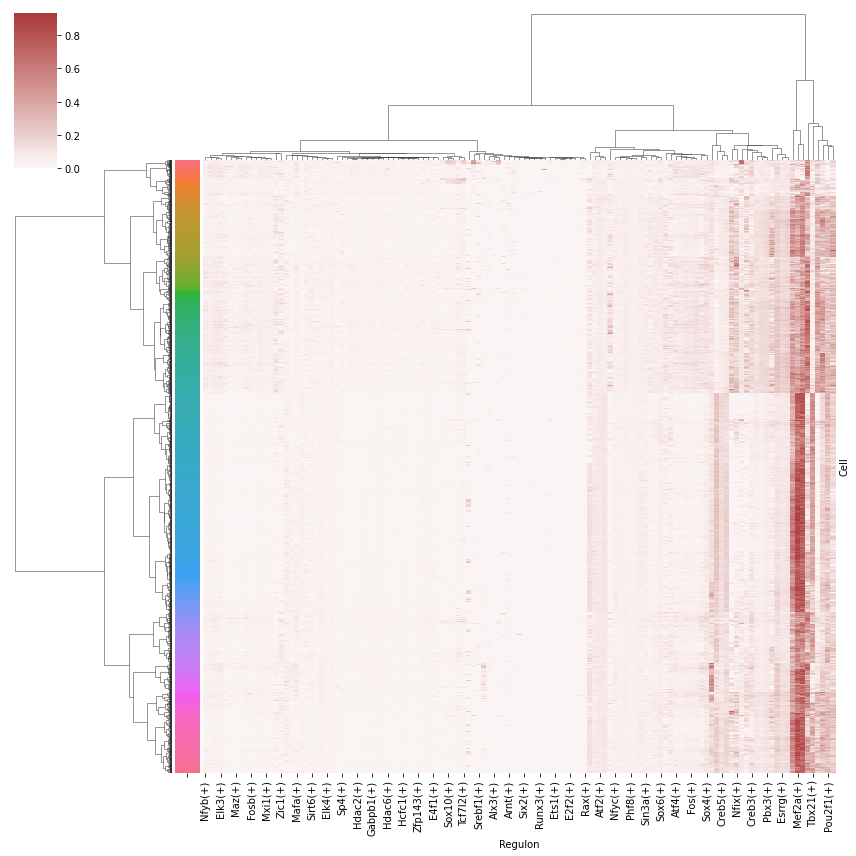

In [24]:
# Create a categorical palette and map it 
pal = sns.husl_palette(n_colors=cell_type_nrs.max())
lut = dict(zip(sorted(cell_type_nrs.unique()), pal))
cell_type_colors = pd.Series(cell_type_nrs.values, index=auc_mtx.index).map(lut)

# Plot and save
result = sns.clustermap(auc_mtx, metric='euclidean', method='ward', cmap='vlag', center=0,
                        row_colors=cell_type_colors, figsize=(12,12), yticklabels=False);

result.savefig(os.path.join(OUT_FOLDER,'pyscenic_cell_types.png'))

In [25]:
auc_mtx2 = auc_mtx.copy()

In [27]:
# Write out cell types
cell_types = pd.Series(cell_type_nrs.values, name='CellType', index=auc_mtx.index)
cell_types.to_pickle(os.path.join(OUT_FOLDER,'pyscenic_celltypes.pickle'))

## Which TFs are behind each of the cell types?

In [ ]:
#cell_types = pd.read_pickle('2020-02-17_nuc_celltypes.pickle')

In [28]:
# For a given cell type, what are its most important regulons?
ct = 4
auc_mtx2.loc[cell_types[cell_types == ct].index.values].sum(axis=0).sort_values(ascending=False)

Regulon
Hmgb3(+)    5.976653
Foxd3(+)    5.658652
Lef1(+)     3.716666
Cebpd(+)    3.529422
Dlx1(+)     2.736652
              ...   
Klf5(+)     0.001882
Pitx3(+)    0.000000
Spz1(+)     0.000000
Arnt(+)     0.000000
Runx3(+)    0.000000
Length: 125, dtype: float64

In [29]:
# Select top x% regulons
high_regulons = {}

# Cut-off above which I keep regulons
fraction = 0.8
for ct in sorted(cell_types.unique()):
    aux_sums = auc_mtx2.loc[cell_types[cell_types == ct].index.values].sum(axis=0)
    aux_cumsum = (aux_sums.sort_values().cumsum() / aux_sums.sum())
    high_regulons[ct] = aux_cumsum[aux_cumsum > fraction].index.values

In [30]:
# Output a list of top regulons, to do some literature check
print("Keeping only regulons above {}\n".format(fraction))
for ct, hr in high_regulons.items():
    print("Cell type {}, nr of regulons {}:".format(ct, len(hr)))
    print([name[:-3] for name in sorted(hr)])
    print("---")

Keeping only regulons above 0.8

Cell type 1, nr of regulons 7:
['Cebpd', 'Dlx1', 'Foxd3', 'Hmgb3', 'Pax6', 'Peg3', 'Zfp398']
---
Cell type 2, nr of regulons 5:
['Cebpd', 'Dlx1', 'Foxd3', 'Hmgb3', 'Peg3']
---
Cell type 3, nr of regulons 5:
['Cebpd', 'Foxd3', 'Hmgb3', 'Lef1', 'Nfix']
---
Cell type 4, nr of regulons 6:
['Cebpd', 'Dlx1', 'Foxd3', 'Hmgb3', 'Lef1', 'Sox10']
---
Cell type 5, nr of regulons 5:
['Cebpd', 'Foxd3', 'Hmgb3', 'Lef1', 'Sox10']
---
Cell type 6, nr of regulons 5:
['Cebpd', 'Foxd3', 'Hmgb3', 'Lef1', 'Sox10']
---
Cell type 7, nr of regulons 5:
['Alx3', 'Bcl11a', 'Cebpd', 'Foxd3', 'Hmgb3']
---
Cell type 8, nr of regulons 5:
['Bcl11a', 'Cebpd', 'Foxd3', 'Hmgb3', 'Lef1']
---
Cell type 9, nr of regulons 5:
['Cebpd', 'Foxd3', 'Hmgb3', 'Lef1', 'Srebf1']
---
Cell type 10, nr of regulons 5:
['Cebpd', 'Foxd3', 'Hmgb3', 'Lef1', 'Srebf1']
---
Cell type 11, nr of regulons 5:
['Cebpd', 'Foxd3', 'Hmgb3', 'Lef1', 'Srebf1']
---
Cell type 12, nr of regulons 5:
['Foxp1', 'Hmgb3', 'Irf7'

**Observations**

- As Sara already mentioned a long time ago, the TFs above are often early lineage specification factors.
- Even if we select for mature neurons, cell type 6 has signs of not being mature (Pax6, Bcl6, Nfic).

In [31]:
# Shared regulons across cell types
counted_high_regulons = {}
for hr in high_regulons.values():
    for r in hr:
        counted_high_regulons[r] = counted_high_regulons.get(r, 0) + 1

max_c = max(counted_high_regulons.values())      
for r,c in sorted(counted_high_regulons.items()):
    if c > max_c - 3:
        print("{}: {}".format(r, c))

Peg3(+): 540


**Observations**

- Not sure what to interpret from this list...

## Network view on regulons

In [32]:
# Function to write out regulons (TF + targets) as nodes and 
# edges of a graph/network. I then use cytoscape to visualize
# the network, but I should really transition to the python
# package 'networkx' as it removes an external software dependency.

from typing import List, Mapping, Sequence, Optional
from pyscenic.genesig import Regulon
import networkx as nx

# Export regulons as GraphML
def export_regulons(regulons: Sequence[Regulon], fname: str) -> None:
    """
    Export regulons as GraphML.
    :param regulons: The sequence of regulons to export.
    :param fname: The name of the file to create.
    """
#     all_node_names = set(tf_names)
    all_node_names = set([r.transcription_factor for r in regulons])
    
    graph = nx.DiGraph()
    for regulon in regulons:
        src_name = regulon.transcription_factor
        graph.add_node(src_name, group='transcription_factor', label=src_name)
        
        for dst_name, edge_strength in regulon.gene2weight.items():
#             graph.add_node(dst_name, group=node_type)
            if dst_name in all_node_names:
                graph.add_edge(src_name, dst_name, weight=float(edge_strength))
    
    # Remove all nodes that do not have any in/out edges
    lonely_genes = [n for n in graph if graph.degree(n) == 0]
    graph.remove_nodes_from(lonely_genes)
    
    nx.readwrite.write_graphml(graph, fname)

In [34]:
# Write cell type specific networks to file for Cytoscape
for ct, hregulons in high_regulons.items():
    export_regulons([r for r in regulons if r.name in set(hregulons)], 
                    # "celltype_networks/2020-02-17_nuc_regulons_ctype_{}.graphml".format(ct))
                    os.path.join(OUT_FOLDER,"celltype_networks/pyscenic_nuc_regulons_ctype_{}.graphml").format(ct))
    

In [35]:
from operator import itemgetter

def shared_targets(regulons, tf_only=False):
    """
    Each cell type has a list of high-scoring regulons. I want to know what genes 
    they target and how often each gene is regulated.
    """
    # Dict of target genes and how often they are targeted by the top regulons of a cell type
    target_genes = {}
    
    for regulon in regulons:
        for g in regulon.gene2weight.keys():
            target_genes[g] = target_genes.get(g, 0) + 1
    
    if tf_only:
        my_tfs = set(tf_names)
        # Return a dict of counts with the corresponding tfs
        counted_genes = {}
        for g,c in target_genes.items():
            if g in my_tfs:
                counted_genes.setdefault(c, []).append(g)
        counted_genes = {c: sorted(g) for c, g in counted_genes.items()}
        
    else:
        # Return a dict of counts with the corresponding genes
        counted_genes = {}
        for g,c in target_genes.items():
            counted_genes.setdefault(c, []).append(g)
        counted_genes = {c: sorted(g) for c, g in counted_genes.items()}
    
    return counted_genes

In [41]:
# Look at top regulons per cell type and their target transcription factors.
# In other words, I only want to look at TFs that are both regulating 
# and being regulated and I ignore other genes that are regulated by TFs.

mincount = 1
for ct, hregulons in high_regulons.items():
    print("# Cell type {}".format(ct))
    aux = shared_targets([r for r in regulons if r.name in set(hregulons)], tf_only=True)
    for c, g in sorted(aux.items()):
        if c > mincount:
            print("Occurrence: {}, TFs as target: {}".format(c, g))
    print("---")

# Cell type 1
Occurrence: 2, TFs as target: ['Etv1']
---
# Cell type 2
---
# Cell type 3
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 4
Occurrence: 2, TFs as target: ['Btbd11', 'Cbx2', 'Foxd3', 'Hes1', 'Lef1', 'Prox1', 'Tcf7l2', 'Thra', 'Zfp36l1']
Occurrence: 3, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 5
Occurrence: 2, TFs as target: ['Btbd11', 'Cbx2', 'Foxd3', 'Hes1', 'Lef1', 'Prox1', 'Tcf7l2', 'Zfp36l1']
Occurrence: 3, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 6
Occurrence: 2, TFs as target: ['Btbd11', 'Cbx2', 'Foxd3', 'Hes1', 'Lef1', 'Prox1', 'Tcf7l2', 'Zfp36l1']
Occurrence: 3, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 7
---
# Cell type 8
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 9
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 10
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2', 'Nrarp']
---
# Cell type 11
Occurrence: 2, TFs as target: ['Lmo4', 'Nr2f2'

In [43]:
# Look at top regulons per cell type and their target transcription factors. Do these form little networks? 
mincount = 1
for ct, hregulons in high_regulons.items():
    # Collect all target regulators that are reasonably abundant
    aux = shared_targets([r for r in regulons if r.name in set(hregulons)], tf_only=True)
    # List comprehension also flattens list!
    targets_hregulons = [gname + '(+)' for c, gns in aux.items() if c > mincount for gname in gns]
    export_regulons([r for r in regulons if r.name in set(targets_hregulons)], 
                     #"targets_regulons_networks/2020-02-17_nuc_targets_ctype_{}.graphml".format(ct))
                     os.path.join(OUT_FOLDER,"targets_regulons_networks/pyscenic_nuc_regulons_ctype_{}.graphml").format(ct))

## Observations  and future work

Getting pyscenic to work and verifying it does not do completely weird stuff was my first priority. I am quite confident that it works as intended here.

A long time ago, I mapped cell types of pyscenic to the Louvain clustering cell types, and they overlapped nicely. I have not (yet) done that here, but it should be relatively easy as cell ids are easily compared.

I have only scratched the surface on looking at the networks that the TFs + targets make. I am sure there is more to find out. One thing that would be cool, is to derive some consensus network for all neuronal types and see if one can implement some (Boolean) dynamics on it. What attractors does it have? Do these match neuronal cell types? For this, we should also take into account inhibiting TFs in step 1 (function `modules_from_adjacencies`).